# Multi-inversion FWIGAN with DeepWave: Marmousi Model 
Prepared by Muhammad Izzatullah, KAUST

## Mount GoogleDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install and import dependencies

In [ ]:
!pip install deepwave
!pip install tqdm

  Using cached deepwave-0.0.8.tar.gz (32 kB)
  Created wheel for deepwave: filename=deepwave-0.0.8-cp37-cp37m-linux_x86_64.whl size=22429925 sha256=fe48aa651392f519b805697b6530c1d8e6b445a5b42666fa1a80557df391b4c2
  Stored in directory: /root/.cache/pip/wheels/44/7f/8c/4b22b69688ac828b9d0402943dc78e102a592a609891f09a94
Successfully built deepwave


In [ ]:
import os
import math
import random
import torch
import time
import torch
import scipy.ndimage
import torch.nn as nn
import numpy as np
import deepwave as dw
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim import Optimizer
from torch import Tensor
from typing import List, Optional

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Oct  4 11:50:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Helper functions

In [ ]:
# Load true model
def load_true_model(file):
    return torch.load(file)


# Data normalization function
def data_normalization(data):
    data_max, _ = data.max(dim=0, keepdim=True)
    # Normalize amplitudes by dividing by the maximum amplitude of each receiver
    return data / (data_max.abs() + 1e-10)


def generate_data(truth, source, xs, xr, dx, dt, device="cpu"):
    prop = dw.scalar.Propagator({'vp': truth.to(device)}, dx)
    data = prop(source, xs, xr, dt)
    data = data_normalization(data).permute(1, 0, 2).unsqueeze(0)
    return data.detach()


# Adding noise to data
def add_noise(data, noise_level, kind="gauss", device="cpu"):
  # BATCH_SIZE, C, H, W = data.shape
  # noise = noise_level * torch.randn((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
  noise = noise_level * torch.randn_like(data)

  if kind == "gauss":
    SNR = 20 * torch.log10(torch.norm(data)/torch.norm(noise))
    noise_info = {'SNR': SNR.cpu().detach()}
    noisy_data = data + noise
    return noisy_data, noise_info

  if kind == "laplace":
    noise = torch.sign(0.5 - noise)*(1.0/np.sqrt(2.0))*torch.log(2*torch.minimum(noise,1 - noise))
    SNR = 20 * torch.log10(torch.norm(data)/torch.norm(noise))
    noise_info = {'SNR': SNR.cpu().detach()}

    noise = sigma * noise
    return noisy_data, noise_info

  else:
    raise NotImplementedError(f"No such kind of noise")
    

# Transform to bounded space
def bounded_transform(model, vmin, vmax):
  return vmin + (vmax - vmin) / (1 + torch.exp(-model))


# Gradient penalty function
def gradient_penalty(critic, dtrue, dsim, device="cpu"):
    BATCH_SIZE, C, H, W = dtrue.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_data = dtrue * beta + dsim.detach() * (1 - beta)
    interpolated_data.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_data)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_data,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    return torch.mean((gradient_norm - 1) ** 2)


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def save_updates(model, filename="my_checkpoint.pth.tar"):
    print("=> Saving update")
    updates = {
        "model": model.model.cpu().detach(),
        "sigma": model.sigma.cpu().detach(),
        "source": model.source.cpu().detach(),
    }
    torch.save(updates, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location="cuda")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def load_updates(checkpoint_file, filename="my_checkpoint.pth.tar"):
    print("=> Loading updates")
    updates = torch.load(checkpoint_file, map_location="cuda")

    return updates['model'], updates['sigma'], updates['source']


def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Generator and Critic Class

In [ ]:
# Generator Class
class Generator(nn.Module):
    def __init__(self, model, sigma, source, batch, dx, dt, noise=False, device="cpu"):
        super(Generator, self).__init__()
        self.noise = noise
        self.dx = dx
        self.dt = dt
        self.batch = batch
        self.device = device
        self.model = model.to(device)
        self.source = source.to(device)
        self.sigma = sigma.to(device)
        
        self.model.requires_grad = True
        self.source.requires_grad = True

        if noise:
          self.sigma.requires_grad = True

    def forward(self, xs, xr):
        source = self.source.repeat(1, self.batch , 1)
        prop = dw.scalar.Propagator({'vp': self.model}, self.dx)
        data = prop(source, xs, xr, self.dt)
        data = data_normalization(data).permute(1, 0, 2).unsqueeze(0)
        if self.noise:
          data = self.data_noise(data, self.sigma, self.device)
        return data

    # Adding noise to data
    def data_noise(self, data, sigma, device):
      # BATCH_SIZE, C, H, W = data.shape
      noise = sigma * torch.randn_like(data)
      return data + noise


# Critic Class
class Critic(nn.Module):

    def __init__(self, in_channels, nt, n_receivers):
        super().__init__()

        dense_neuron = int((in_channels * 32) * np.floor(nt / 32)) #np.floor(n_receivers / 32)

        self.conv_block = nn.Sequential(
            # in_channel, out_channel, kernel_size, stride=1, padding=0
            # width and height: (n + 2*pad - ks)//stride + 1
            nn.Conv2d(in_channels, in_channels * 2, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LeakyReLU(0.1),

            nn.Conv2d(in_channels * 2, in_channels * 4, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LeakyReLU(0.1),

            nn.Conv2d(in_channels * 4, in_channels * 8, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LeakyReLU(0.1),

            nn.Conv2d(in_channels * 8, in_channels * 16, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LeakyReLU(0.1),

            nn.Conv2d(in_channels * 16, in_channels * 32, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LeakyReLU(0.1),
        )

        self.dense_block = nn.Sequential(
            nn.Linear(dense_neuron, dense_neuron // 2),
            nn.LeakyReLU(0.1),
            nn.Linear(dense_neuron // 2, 2000),
            nn.LeakyReLU(0.1),
            nn.Linear(2000, 1),
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = x.reshape(1, -1)
        x = self.dense_block(x)
        return x

## Training function

In [ ]:
def train_fn(
        epochs,
        data,
        generator,
        critic,
        generator_opt,
        critic_opt,
        generator_scheduler,
        critic_scheduler,
        gen_loss,
        crit_loss,
        scaler_generator,
        scaler_critic,
        source,
        xs,
        xr,
):
    batches = tqdm(range(BATCHES))

    for b in batches:
        batch_xs = xs[b::BATCHES]
        batch_xr = xr[b::BATCHES]
        batch_data_sim = generator(batch_xs, batch_xr)
        batch_data_true = data[:, b::BATCHES, ...]

        # critic
        mean_critic_loss = 0.0
        for _ in range(CRITIC_CYCLE):
          with torch.cuda.amp.autocast():
              critic_sim = critic(batch_data_sim)
              critic_true = critic(batch_data_true)

              gp = gradient_penalty(critic, batch_data_true, batch_data_sim, device=DEVICE)

              critic_loss = critic_sim.sum() - critic_true.sum() + 10.0 * gp + (0.001 * torch.mean(critic_true ** 2))

              mean_critic_loss += critic_loss.item() / CRITIC_CYCLE
          
          critic_opt.zero_grad()
          scaler_critic.scale(critic_loss).backward(retain_graph=True)
          scaler_critic.unscale_(critic_opt)
          nn.utils.clip_grad_value_(critic.parameters(), clip_value=1e6)
          scaler_critic.step(critic_opt)
          scaler_critic.update()
        crit_loss += [mean_critic_loss]

        with torch.cuda.amp.autocast():
            generator_loss = -critic(batch_data_sim).sum()
        
        generator_opt.zero_grad()       
        scaler_generator.scale(generator_loss).backward()
        scaler_generator.unscale_(generator_opt)
        nn.utils.clip_grad_value_(generator.model, clip_value=1e3)
        scaler_generator.step(generator_opt)
        scaler_generator.update()
        
        gen_loss += [generator_loss.item()]

        batches.set_postfix(
            Epochs = epoch,
            gen_loss=generator_loss.item(),
            mean_critic_loss=mean_critic_loss,
            sigma = generator.sigma.item()
        )

    generator_scheduler.step()
    critic_scheduler.step()

## Simulation setup

In [ ]:
TRUTH = load_true_model('/models/marmousi_3.bin')
MODEL_INIT = load_true_model('/models/marmousi_30.bin')

VMIN, VMAX = np.percentile(MODEL_INIT.numpy(), [2,98]) # For plotting

# Set parameters
FREQ = 7  # Hz
DX_TRUTH = 3.0  # m
DX = 30.0  # m
DT = 0.003  # ms
NZ = MODEL_INIT.size(0)  # Grid: 100  3000.0 m
NX = MODEL_INIT.size(1)  # Grid: 310  9300.0 m
NT = int(6 / DT)  # Grid [sec/DT]: 2000
DIMS = 2  # Physical dimension
SOURCE_SPACING = 300.00  # m
RECEIVER_SPACING = 150.00  # m
SHOTS = 30 # Int
SOURCES_PER_SHOTS = 1  # Int
RECEIVERS = 60 #Int

NOISE = True
NOISE_LEVEL = 0.05
SIGMA = torch.tensor(1.0)

DEVICE = torch.device(0 if torch.cuda.is_available() else 'cpu')
NUM_WORKERS = 4
BATCHES = 6
SHOTS_PER_BATCH = int(SHOTS / BATCHES)
EPOCHS = 401
CRITIC_CYCLE = SHOTS_PER_BATCH + 1

LOAD_MODEL = False
SAVE_MODEL = True
CHECKPOINT_GEN = "/models/FWIGAN_noisy_generator_marmousi.pth"
CHECKPOINT_CRITIC = "/models/FWIGAN_noisy_critic_marmousi.pth"

## Initialize the simulation

In [ ]:
# Use PyTorch Backend and seed everything
torch.backends.cudnn.benchmarks = True
seed_everything()

# Create arrays containing the source and receiver locations
# xs: Source locations [num_shots, num_sources_per_shot, num_dimensions]
xs = torch.zeros(SHOTS, SOURCES_PER_SHOTS, DIMS, device=DEVICE)
xs[:, 0, 1] = torch.arange(SHOTS).float() * SOURCE_SPACING

# xr: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]
xr = torch.zeros(SHOTS, RECEIVERS, DIMS, device=DEVICE)
xr[0, :, 1] = torch.arange(RECEIVERS).float() * RECEIVER_SPACING
xr[:, :, 1] = xr[0, :, 1].repeat(SHOTS, 1)

# Create true source amplitudes [nt, num_shots, num_sources_per_shot]
source = (dw.wavelets.ricker(FREQ, NT, DT, 1 / FREQ)
          .reshape(-1, 1, 1)
          .repeat(1, SHOTS, SOURCES_PER_SHOTS)).to(DEVICE)

# Generate clean true data
clean_data = generate_data(TRUTH, source, xs, xr, DX_TRUTH, DT, DEVICE)
noisy_data, noise_info = add_noise(clean_data, NOISE_LEVEL, "gauss", DEVICE)

# Create initial source guess
source_init = (dw.wavelets.ricker(FREQ+3, NT, DT, 1/FREQ)
                          .reshape(-1, 1, 1))

# Generate initial model
model_init = scipy.ndimage.gaussian_filter(MODEL_INIT.cpu().detach().numpy(), sigma=10)
model_init = torch.tensor(model_init)
model = model_init.clone()

# Initialize Generator and Critic
generator = Generator(model, SIGMA, source_init, SHOTS_PER_BATCH, DX, DT, NOISE, DEVICE).to(DEVICE)
critic = Critic(SHOTS_PER_BATCH, NT, RECEIVERS).to(DEVICE)

# Initialize Optimizers and Scheduler
critic_opt = torch.optim.Adam(critic.parameters(), lr=1e-3, betas=(0.5, 0.9))
critic_scheduler = torch.optim.lr_scheduler.StepLR(critic_opt, 100, gamma=0.5)

generator_opt =  torch.optim.Adam([{'params': generator.model, 'lr':5, 'betas':(0.5, 0.9)}, 
                                   {'params': generator.sigma, 'lr':1e-2, 'betas':(0.5, 0.9)},
                                  {'params': generator.source, 'lr':1e-3, 'betas':(0.5, 0.9)}])
generator_scheduler = torch.optim.lr_scheduler.StepLR(generator_opt, 150, gamma=0.5)

scaler_critic = torch.cuda.amp.GradScaler()
scaler_generator = torch.cuda.amp.GradScaler()

In [ ]:
noise_info

{'SNR': tensor(8.1760)}

## Plotting model and data

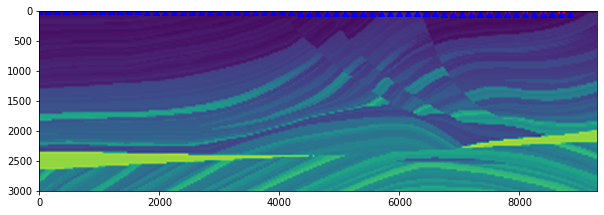

In [ ]:
xxs = torch.arange(SHOTS).float() * SOURCE_SPACING
xxr = torch.arange(RECEIVERS).float() * RECEIVER_SPACING

plt.figure(figsize=(10,8))
plt.imshow(TRUTH, extent=[0, DX*NX, DX*NZ, 0])
plt.plot(xxs, torch.arange(len(xxs)), 'r*')
plt.plot(xxr, torch.arange(len(xxr)), 'b^')

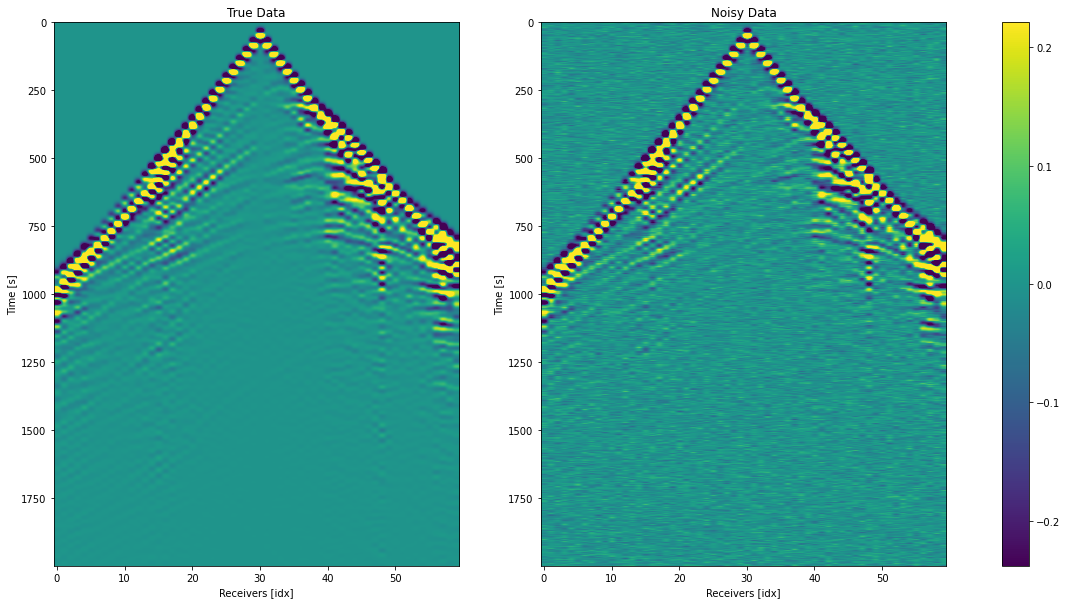

In [ ]:
vmin, vmax = np.percentile(clean_data[0, 15, ...].cpu().numpy(), [2,98])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(clean_data[0, 15, ...].cpu().numpy(), aspect='auto', vmin=vmin, vmax=vmax)
ax1.set_title("True Data")
ax1.set(xlabel=r"Receivers [idx]", ylabel=r"Time [s]")

im = ax2.imshow(noisy_data[0, 15, ...].cpu().numpy(), aspect='auto', vmin=vmin, vmax=vmax)
ax2.set_title("Noisy Data")
ax2.set(xlabel=r"Receivers [idx]", ylabel=r"Time [s]")

fig.colorbar(im, ax=(ax1, ax2), shrink=1, location='right')

## Main: Run simulation

In [ ]:
# Training Loop
gen_loss = []
crit_loss = []

if LOAD_MODEL:
    load_checkpoint(CHECKPOINT_GEN, generator, generator_opt, 5)
    load_checkpoint(CHECKPOINT_CRITIC, critic, critic_opt, 1e-3)

generator.train()
critic.train()

# Start training
t_start = time.time()
for epoch in range(EPOCHS):
    train_fn(
        epoch,
        noisy_data,
        generator,
        critic,
        generator_opt,
        critic_opt,
        generator_scheduler,
        critic_scheduler,
        gen_loss,
        crit_loss,
        scaler_generator,
        scaler_critic,
        source,
        xs,
        xr,
    )

    if epoch % 10 == 0:
        plt.figure(figsize=(8, 4))
        plt.imshow(generator.model.cpu().detach().numpy(), vmin=VMIN, vmax=VMAX,
                  cmap='viridis')
        plt.show()

    if epoch % 50 == 0 and SAVE_MODEL:
        save_checkpoint(generator, generator_opt, filename=CHECKPOINT_GEN)
        save_checkpoint(critic, critic_opt, filename=CHECKPOINT_CRITIC)
t_end = time.time()
print('Runtime:', t_end - t_start)

Output hidden; open in https://colab.research.google.com to view.

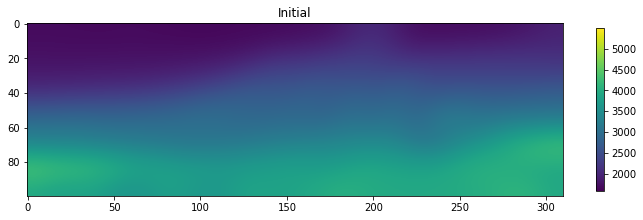

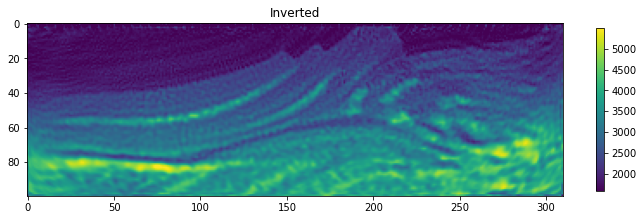

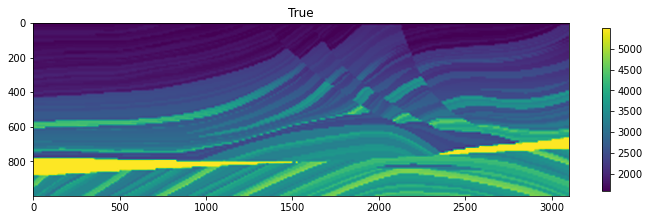

In [ ]:
# Plot initial, inverted, and true models
model_final = generator.model.cpu().detach().numpy()

figsize = (12, 6)
plt.figure(figsize=figsize)
plt.imshow(model_init.numpy(), vmin=VMIN, vmax=VMAX, cmap='viridis')
plt.title('Initial');
plt.colorbar(shrink=0.5)
plt.figure(figsize=figsize)
plt.imshow(model_final, vmin=VMIN, vmax=VMAX, cmap='viridis')
plt.title('Inverted');
plt.colorbar(shrink=0.5)
plt.figure(figsize=figsize)
plt.imshow(TRUTH.numpy(), vmin=VMIN, vmax=VMAX, cmap='viridis')
plt.title('True');
plt.colorbar(shrink=0.5)

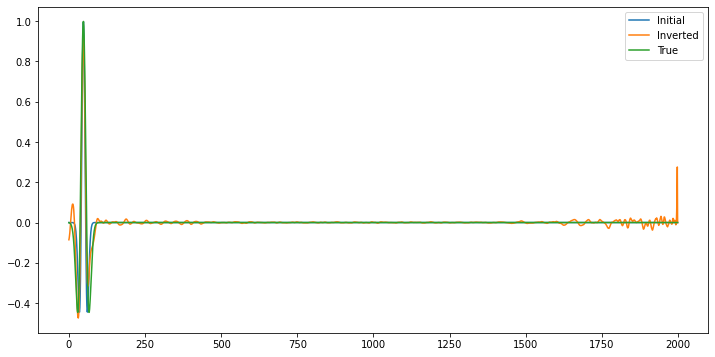

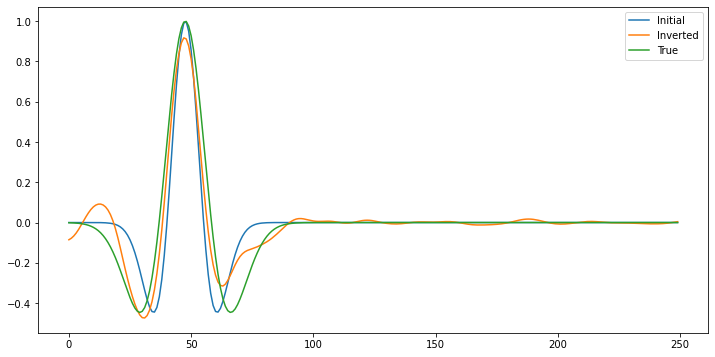

In [ ]:
# Plot initial, inverted, and true source amplitudes
figsize = (12, 6)
plt.figure(figsize=figsize)
plt.plot(source_init.numpy().ravel(), label='Initial')
plt.plot(generator.source.cpu().detach().numpy().ravel(), label='Inverted')
plt.plot(source[:,0,0].cpu().detach().numpy().ravel(), label='True')
plt.legend();

# Zoom-in to wavelet
t = 250
figsize = (12, 6)
plt.figure(figsize=figsize)
plt.plot(source_init.numpy().ravel()[:t], label='Initial')
plt.plot(generator.source.cpu().detach().numpy().ravel()[:t], label='Inverted')
plt.plot(source[:,0,0].cpu().detach().numpy().ravel()[:t], label='True')
plt.legend();